# Surface Air Quality and Meteorological Observations in the MASP

Developed by Alejandro Delgado

e-mail: adelgado@iag.usp.br


Import Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
import cartopy
from cartopy import crs # becareful with this package, doesn't work well
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import OCEAN
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords
import wrf

## Merge the files of air quality and meteorological parameters into a single CSV file

We have several air stations where air quality and meteorological parameters are monitored each hour by [CETESB](https://qualar.cetesb.sp.gov.br/qualar/home.do) in the São Paulo state. The parameters are follows:

* **Meteorological parameters**:

  - temperature at 2 m above ground in ºC (`tc`)
  - relative humidity at 2 m above ground in % (`rh`)
  - solar radiation in W/m$^2$ (`sr`)
  - wind speed at 10 m above ground in m/s (`ws`)
  - wind direction at 10 m above ground in º (`wd`)

* **Air quality parameters**:

  - surface ozone concentration in $\mu$g m$^{-3}$ (`o3`)
  - nitrogen monoxide concentration in $\mu$g m$^{-3}$ (`no`)
  - nitrogen dioxide concentration in $\mu$g m$^{-3}$  (`no2`)
  - carbon monoxide concentration in ppm (`co`)

I downloaded air quality and meteorological parameters from CETESB for all stations only for September (years 2016, 2017 and 2018). To do this, I used `donwloaded_CETESB.py` and `qualar_py.py` Python scripts. The repository of these scripts are in my [github](https://github.com/adelgadop/PythonObsData).

In [2]:
stations = pd.read_csv('cetesb_station_2017_codes_qualr.csv',
                      encoding = "ISO-8859-1")
stations[stations['name'] == 'Guarulhos']
stations

,name,lat,lon,code
0,Americana,-22.724253,-47.339549,290
1,Araçatuba,-21.186841,-50.439317,107
2,Araraquara,-21.782522,-48.185832,106
3,Bauru,-22.326608,-49.092759,108
4,Cambuci,-23.567708,-46.612273,90
...,...,...,...,...
63,S.Miguel Paulista,-23.498526,-46.444803,236
64,Sorocaba,-23.502427,-47.479030,67
65,Taboão da Serra,-23.609324,-46.758294,103
66,Tatuí,-23.360752,-47.870799,256


I downloaded air quality and meteorological parameters of three years (2016-2018), only for 6 stations:

In [3]:
sites = stations.loc[[9,22,39,47,61,67],:]
sites

,name,lat,lon,code
9,Carapicuíba,-23.531395,-46.835780,263
22,Guarulhos-Pimentas,-23.440117,-46.409949,279
39,Parque D.Pedro II,-23.544846,-46.627676,72
47,Ribeirão Preto,-21.153942,-47.828481,288
61,S.José Campos-Jd.Satelite,-23.223645,-45.890800,277
67,Taubaté,-23.032351,-45.575805,280


The map locations of these stations is shown as follow:

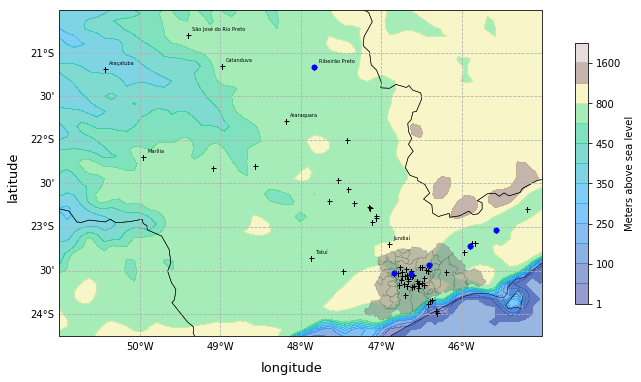

In [4]:
geo_d01 = Dataset('../3_Modeling/geo_em.d01.nc')
geo_d02 = Dataset('../3_Modeling/geo_em.d02.nc')
hgt_d01    = getvar(geo_d01, 'HGT_M')
hgt_d02    = getvar(geo_d02, 'HGT_M')
cart_proj  = get_cartopy(hgt_d01)
lats, lons = latlon_coords(hgt_d01)
lats_d02, lons_d02 = latlon_coords(hgt_d02)

## Chart
fig1 = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=cart_proj)
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')

ax.add_feature(states, linewidth=.5,edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)
ax.set_extent([-51, -45, -24.25, -20.5])
#ax1.coastlines('50m', linewidth=0.8)

# ad MASP
fname = '../3_Modeling/MunRM07.shp'

shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                crs.PlateCarree(), edgecolor='black')
ax.add_feature(shape_feature, linewidth=0.2, edgecolor = 'black', 
                facecolor = 'gray', alpha=0.5)

# Set the contour levels
levels = [1, 50, 100, 200, 250, 300, 
          350, 400, 450, 500, 800, 1300, 
          1600, 2000]

plt.contourf(to_np(lons), to_np(lats), 
                to_np(hgt_d01), levels=levels,
                transform=crs.PlateCarree(),
                cmap=get_cmap("terrain"), alpha = 0.5)
plt.colorbar(ax=ax, label = 'Meters above sea level',shrink=0.8,
            pad = 0.05 )

# draw gridlines
gl = ax.gridlines(draw_labels=True, dms=True, alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.text(-51.65, -22.25, 'latitude', transform=crs.Geodetic(),
         fontsize=13, rotation='vertical')
ax.text(-48.5, -24.65, 'longitude', transform=crs.Geodetic(),
        fontsize=13, rotation='horizontal')

lon = stations.lon.values
lat = stations.lat.values
num = [1,2,10,30,33,47,59,66] # index of stations
for i in num:
    ax.text(lon[i]+0.05, lat[i]+0.05, stations.name.values[i], transform=crs.Geodetic(),
            fontsize=5, rotation='horizontal')
ax.plot(lon, lat,'+',markersize=5, color = 'k', transform=crs.Geodetic())
ax.plot(sites.lon.values, sites.lat.values,'o',
        markersize=5, color = 'b', transform=crs.Geodetic());
fig1.savefig("../4_Draft_Report/Dissertation/fig/map_stations.pdf",bbox_inches='tight');

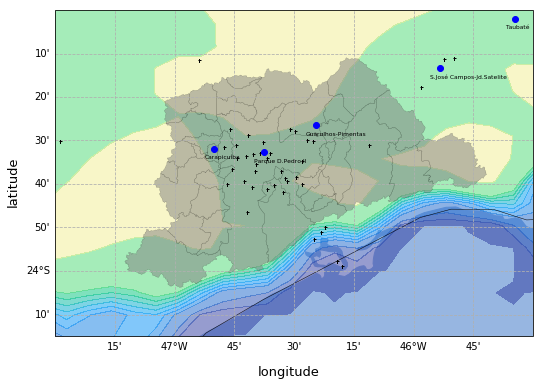

In [5]:
## Chart
fig2 = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=cart_proj)
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')

ax.add_feature(states, linewidth=.5,edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)
ax.set_extent([-47.5, -45.5, -24.25, -23.0])
#ax1.coastlines('50m', linewidth=0.8)

# ad MASP
fname = '../3_Modeling/MunRM07.shp'

shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                crs.PlateCarree(), edgecolor='black')
ax.add_feature(shape_feature, linewidth=0.2, edgecolor = 'black', 
                facecolor = 'gray', alpha=0.5)

# Set the contour levels
levels = [1, 50, 100, 200, 250, 300, 
          350, 400, 450, 500, 800, 1300, 
          1600, 2000]

plt.contourf(to_np(lons), to_np(lats), 
                to_np(hgt_d01), levels=levels,
                transform=crs.PlateCarree(),
                cmap=get_cmap("terrain"), alpha = 0.5)

# draw gridlines
gl = ax.gridlines(draw_labels=True, dms=True, alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.text(-47.7, -23.6, 'latitude', transform=crs.Geodetic(),
         fontsize=13, rotation='vertical')
ax.text(-46.65, -24.40, 'longitude', transform=crs.Geodetic(),
        fontsize=13, rotation='horizontal')

lon = stations.lon.values
lat = stations.lat.values
num = [0,1,2,4,5] # index of stations
for i in num:
    ax.text(sites.lon.values[i]-0.04, sites.lat.values[i]-0.04, 
            sites.name.values[i], transform=crs.Geodetic(),
            fontsize=6, rotation='horizontal')
ax.plot(lon, lat,'+',markersize=3, color = 'k', transform=crs.Geodetic())
ax.plot(sites.lon.values, sites.lat.values,'o',
        markersize=6, color = 'b', transform=crs.Geodetic())
fig2.savefig("../4_Draft_Report/Dissertation/fig/masp_stations.pdf",bbox_inches='tight');

Meteorological parameters

In [6]:
f16 = [file for file in os.listdir('./data/met/Y2016/')]
f17 = [file for file in os.listdir('./data/met/Y2017/')]
f18 = [file for file in os.listdir('./data/met/Y2018/')]

# Function
def readDat(files, path = './data/met/'):
    Data = pd.DataFrame()
    
    for file in files:
        df = pd.read_csv(path + file)
        Data = pd.concat([Data,df])
    return Data
# End

met16 = readDat(f16, path = './data/met/Y2016/')
met17 = readDat(f17, path = './data/met/Y2017/')
met18 = readDat(f18, path = './data/met/Y2018/')

metData = pd.concat([met16,met17,met18])
metData

,date,tc,rh,sr,ws,wd,code
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,263
1,2016-01-01 01:00:00,21.7,89.0,0.0,2.2,14.0,263
2,2016-01-01 02:00:00,21.4,90.0,0.0,2.5,19.0,263
3,2016-01-01 03:00:00,21.5,89.0,0.0,2.3,22.0,263
4,2016-01-01 04:00:00,21.4,90.0,0.0,1.8,346.0,263
...,...,...,...,...,...,...,...
8756,2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,72
8757,2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,72
8758,2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,72
8759,2018-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,72


We add an another column call `station`:

In [7]:
metData['station'] = [stations[stations.code == i].name.values[0] for i in metData.code]
metData

,date,tc,rh,sr,ws,wd,code,station
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,263,Carapicuíba
1,2016-01-01 01:00:00,21.7,89.0,0.0,2.2,14.0,263,Carapicuíba
2,2016-01-01 02:00:00,21.4,90.0,0.0,2.5,19.0,263,Carapicuíba
3,2016-01-01 03:00:00,21.5,89.0,0.0,2.3,22.0,263,Carapicuíba
4,2016-01-01 04:00:00,21.4,90.0,0.0,1.8,346.0,263,Carapicuíba
...,...,...,...,...,...,...,...,...
8756,2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II
8757,2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II
8758,2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II
8759,2018-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II


Air quality parameters

In [8]:
f16 = [file for file in os.listdir('./data/photo/Y2016/')]
f17 = [file for file in os.listdir('./data/photo/Y2017/')]
f18 = [file for file in os.listdir('./data/photo/Y2018/')]

aq16 = readDat(f16, path = './data/photo/Y2016/')
aq17 = readDat(f17, path = './data/photo/Y2017/')
aq18 = readDat(f18, path = './data/photo/Y2018/')

aqData = pd.concat([aq16,aq17,aq18])
aqData.head()

,date,o3,no,no2,co,code
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,280
1,2016-01-01 01:00:00,26.0,NaN,NaN,0.5,280
2,2016-01-01 02:00:00,17.0,0.0,15.0,0.6,280
3,2016-01-01 03:00:00,10.0,0.0,20.0,0.6,280
4,2016-01-01 04:00:00,15.0,0.0,14.0,0.5,280


In [9]:
aqData['station'] = [stations[stations.code == i].name.values[0] for i in aqData.code]
aqData

,date,o3,no,no2,co,code,station
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,280,Taubaté
1,2016-01-01 01:00:00,26.0,NaN,NaN,0.5,280,Taubaté
2,2016-01-01 02:00:00,17.0,0.0,15.0,0.6,280,Taubaté
3,2016-01-01 03:00:00,10.0,0.0,20.0,0.6,280,Taubaté
4,2016-01-01 04:00:00,15.0,0.0,14.0,0.5,280,Taubaté
...,...,...,...,...,...,...,...
8756,2018-12-31 20:00:00,NaN,NaN,NaN,NaN,277,S.José Campos-Jd.Satelite
8757,2018-12-31 21:00:00,NaN,NaN,NaN,NaN,277,S.José Campos-Jd.Satelite
8758,2018-12-31 22:00:00,NaN,NaN,NaN,NaN,277,S.José Campos-Jd.Satelite
8759,2018-12-31 23:00:00,NaN,NaN,NaN,NaN,277,S.José Campos-Jd.Satelite


In [10]:
data = pd.merge(metData, aqData)
data.to_csv("airData.csv", index=False)
data

,date,tc,rh,sr,ws,wd,code,station,o3,no,no2,co
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,263,Carapicuíba,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,21.7,89.0,0.0,2.2,14.0,263,Carapicuíba,22.0,NaN,NaN,0.5
2,2016-01-01 02:00:00,21.4,90.0,0.0,2.5,19.0,263,Carapicuíba,28.0,4.0,14.0,0.5
3,2016-01-01 03:00:00,21.5,89.0,0.0,2.3,22.0,263,Carapicuíba,29.0,3.0,13.0,0.4
4,2016-01-01 04:00:00,21.4,90.0,0.0,1.8,346.0,263,Carapicuíba,28.0,2.0,12.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
157861,2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II,NaN,NaN,NaN,NaN
157862,2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II,NaN,NaN,NaN,NaN
157863,2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II,NaN,NaN,NaN,NaN
157864,2018-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,72,Parque D.Pedro II,NaN,NaN,NaN,NaN


## Datetime format

In [11]:
data.loc[:,'date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data.drop('code', axis = 1, inplace = True)

data.head()

,date,tc,rh,sr,ws,wd,station,o3,no,no2,co
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,Carapicuíba,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,21.7,89.0,0.0,2.2,14.0,Carapicuíba,22.0,NaN,NaN,0.5
2,2016-01-01 02:00:00,21.4,90.0,0.0,2.5,19.0,Carapicuíba,28.0,4.0,14.0,0.5
3,2016-01-01 03:00:00,21.5,89.0,0.0,2.3,22.0,Carapicuíba,29.0,3.0,13.0,0.4
4,2016-01-01 04:00:00,21.4,90.0,0.0,1.8,346.0,Carapicuíba,28.0,2.0,12.0,0.4


## Charts

In [12]:
df = data.iloc[:,1:]
df.index = data.date
df

,tc,rh,sr,ws,wd,station,o3,no,no2,co
date,,,,,,,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,Carapicuíba,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,21.7,89.0,0.0,2.2,14.0,Carapicuíba,22.0,NaN,NaN,0.5
2016-01-01 02:00:00,21.4,90.0,0.0,2.5,19.0,Carapicuíba,28.0,4.0,14.0,0.5
2016-01-01 03:00:00,21.5,89.0,0.0,2.3,22.0,Carapicuíba,29.0,3.0,13.0,0.4
2016-01-01 04:00:00,21.4,90.0,0.0,1.8,346.0,Carapicuíba,28.0,2.0,12.0,0.4
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,Parque D.Pedro II,NaN,NaN,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,Parque D.Pedro II,NaN,NaN,NaN,NaN
2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,Parque D.Pedro II,NaN,NaN,NaN,NaN


### Meteorological parameters

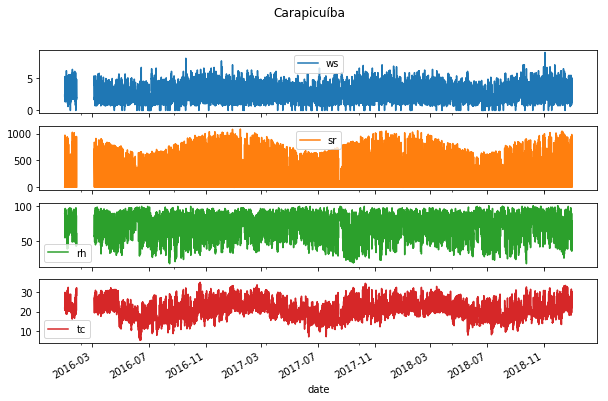

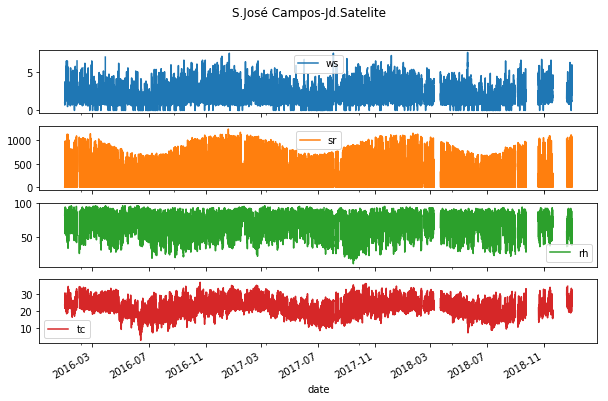

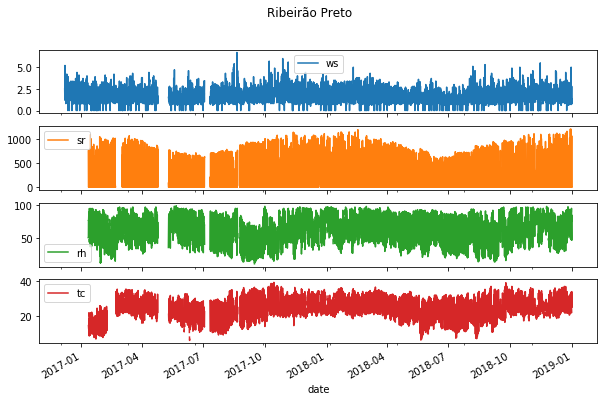

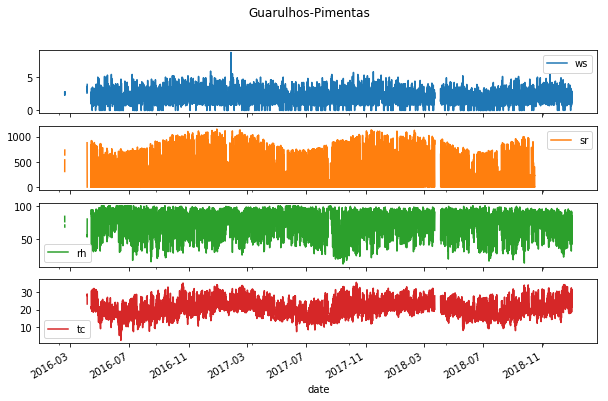

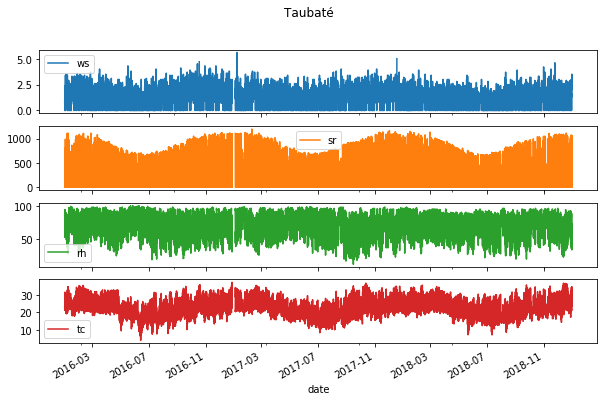

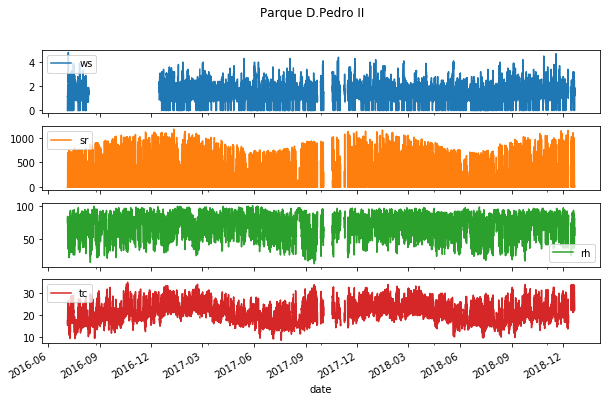

In [13]:
for station in df.station.unique():
    df[df.station == station].plot(y=['ws','sr','rh','tc'],
                                   subplots=True, figsize=(10,6),
                                  title = station)

### Air Quality Parameters

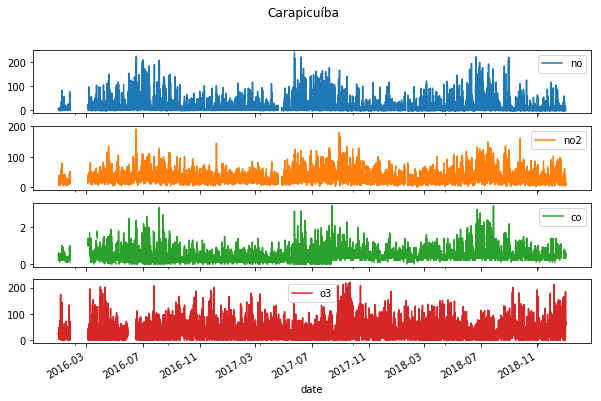

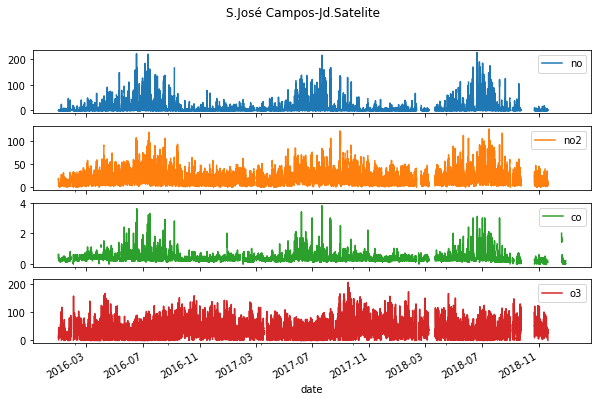

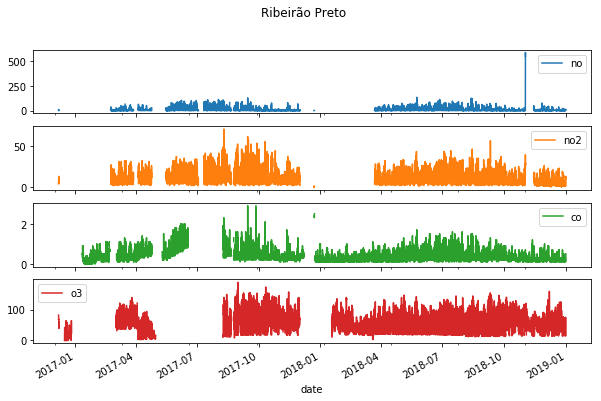

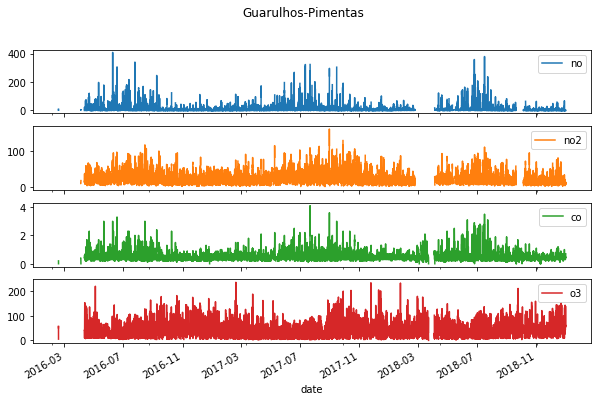

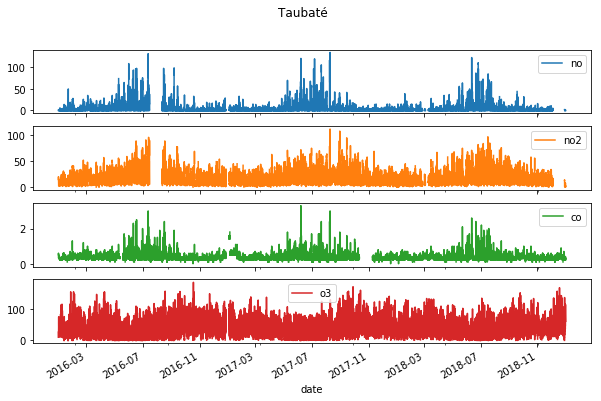

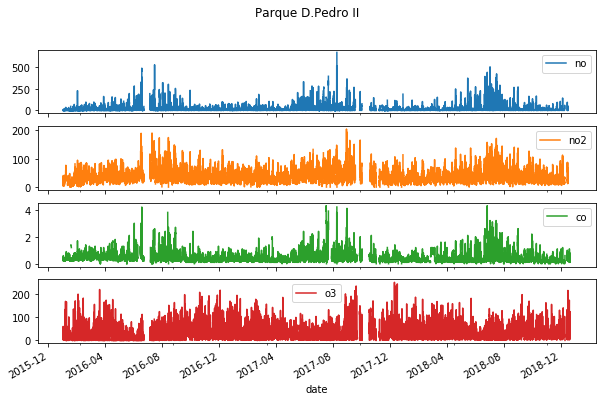

In [14]:
for station in df.station.unique():
    df[df.station == station].plot(y=['no','no2','co','o3'],
                                   subplots=True, figsize=(10,6),
                                  title = station)

#### Average by hour and month

First, we add two columns `month` and `hour`.

In [15]:
df['month'] = df.index.month
df['hour'] = df.index.hour
df

,tc,rh,sr,ws,wd,station,o3,no,no2,co,month,hour
date,,,,,,,,,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,Carapicuíba,NaN,NaN,NaN,NaN,1,0
2016-01-01 01:00:00,21.7,89.0,0.0,2.2,14.0,Carapicuíba,22.0,NaN,NaN,0.5,1,1
2016-01-01 02:00:00,21.4,90.0,0.0,2.5,19.0,Carapicuíba,28.0,4.0,14.0,0.5,1,2
2016-01-01 03:00:00,21.5,89.0,0.0,2.3,22.0,Carapicuíba,29.0,3.0,13.0,0.4,1,3
2016-01-01 04:00:00,21.4,90.0,0.0,1.8,346.0,Carapicuíba,28.0,2.0,12.0,0.4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,Parque D.Pedro II,NaN,NaN,NaN,NaN,12,20
2018-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,Parque D.Pedro II,NaN,NaN,NaN,NaN,12,21
2018-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,Parque D.Pedro II,NaN,NaN,NaN,NaN,12,22


Relation between surface ozone hourly concentrations, temperature and solar radiation 

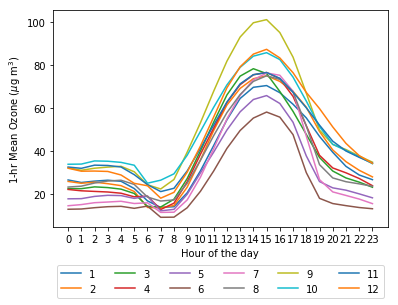

In [16]:
fig, ax = plt.subplots()
ax.set_xticks(df['hour'].unique())
# Average by hour and month for all years and stations
df.groupby(["hour", "month"]).mean()['o3'].unstack().plot(ax=ax)
plt.xlabel('Hour of the day')
plt.ylabel('1-hr Mean Ozone ($\mu$g m$^{3}$)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 6);

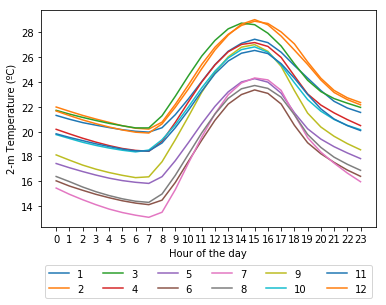

In [17]:
fig, ax = plt.subplots()
ax.set_xticks(df['hour'].unique())
# Average by hour and month for all years and stations
df.groupby(["hour", "month"]).mean()['tc'].unstack().plot(ax=ax)
plt.xlabel('Hour of the day')
plt.ylabel('2-m Temperature (ºC)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 6);

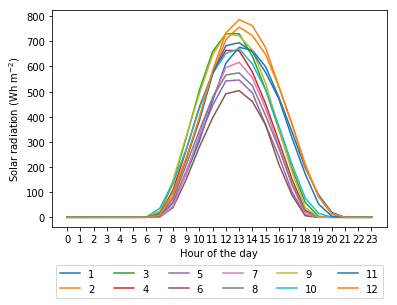

In [18]:
fig, ax = plt.subplots()
ax.set_xticks(df['hour'].unique())
# Average by hour and month for all years and stations
df.groupby(["hour", "month"]).mean()['sr'].unstack().plot(ax=ax)
plt.xlabel('Hour of the day')
plt.ylabel('Solar radiation (Wh m$^{-2}$)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 6);

Then, we group the average data by `hour`, `month`, and `station`:

In [19]:
by_month= df.groupby(['month','hour','station']).mean()[['no','no2']].reset_index()
by_month

,month,hour,station,no,no2
0,1,0,Carapicuíba,6.152941,28.035294
1,1,0,Guarulhos-Pimentas,2.953125,23.734375
2,1,0,Parque D.Pedro II,4.438202,33.842697
3,1,0,Ribeirão Preto,8.000000,10.000000
4,1,0,S.José Campos-Jd.Satelite,0.443182,15.545455
...,...,...,...,...,...
1723,12,23,Guarulhos-Pimentas,2.722222,26.011111
1724,12,23,Parque D.Pedro II,5.828571,40.328571
1725,12,23,Ribeirão Preto,3.562500,11.218750
1726,12,23,S.José Campos-Jd.Satelite,0.629032,18.370968


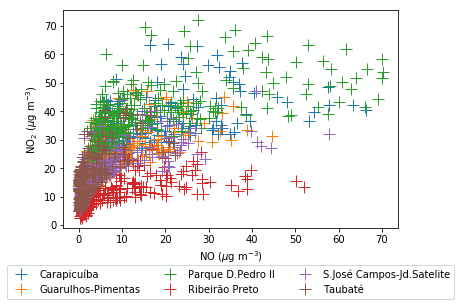

In [20]:
groups = by_month.groupby('station')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.no, group.no2, marker='+', 
            linestyle='', ms=12, label=name)
    ax.set_xlabel('NO ($\mu$g m$^{-3}$)')
    ax.set_ylabel('NO$_2$ ($\mu$g m$^{-3}$)')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 3);
